In [1]:
using DataFrames
using Hungarian
using InferOpt
using Flux
using StatsBase
using MLJ
using ProgressMeter
using Random

In [2]:
using JuMP
using MathOptInterface
using Gurobi
using Graphs
using Plots
using JLD2
using FileIO

In [3]:
include("optimization_Util.jl")

display_solution (generic function with 1 method)

### Training and evaluation of the pipeline using a additive perturbation layer 

In [4]:
ENV["COLUMNS"] = 100
ENV["LINES"] = 100
Random.seed!(67);

In [5]:
file = File(format"JLD2", "Data/train_data.jld2")
train_data = JLD2.load(file)

Dict{String, Any} with 4 entries:
  "Y"   => [[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0;…
  "X"   => Array{Float32, 3}[[0.0 0.0 … 0.0 0.0; 0.0303127 0.0325272 … 0.0179837 0.0136011; 0.02519…
  "X_A" => DataFrame[67×2 DataFrame…
  "X_C" => DataFrame[201×2 DataFrame…

In [6]:
file = File(format"JLD2", "Data/test_data.jld2")
test_data = JLD2.load(file)

Dict{String, Any} with 4 entries:
  "Y"   => [[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0;…
  "X"   => Array{Float32, 3}[[1.0 0.0 … 0.0 0.0; 0.0174359 0.0132141 … 0.00802322 0.0326288; 0.0329…
  "X_A" => DataFrame[54×2 DataFrame…
  "X_C" => DataFrame[177×2 DataFrame…

In [7]:
X_train, X_A_train, X_C_train, Y_train = train_data["X"], train_data["X_A"], train_data["X_C"], train_data["Y"];


In [8]:
X_test, X_A_test, X_C_test, Y_test = test_data["X"], test_data["X_A"], test_data["X_C"], test_data["Y"];

In [9]:
"""
optimizer(cost_matrix)

Wrapper function for the hungarian assignment algorithm.
"""
function optimizer(cost_matrix)
    vector = hungarian(-cost_matrix)[1]
    n, m = size(cost_matrix)

    # Create a matrix of size n×n filled with 0's
    matrix = zeros(Int, n, m)

    # Set the value to 1 at the specified points in the vector
    for i in 1:length(vector)
        matrix[i, vector[i]] = 1
    end
    return matrix
end

optimizer

Additive perturbation Layer using ε \in {0.1, 1} and nb_samples=5

In [20]:
optimizer_layer = PerturbedAdditive(optimizer; ε=0.1, nb_samples=5, seed=69);
loss = FenchelYoungLoss(optimizer_layer);

Linear Model for each entry in the Matrix
with dimension reduction to reduce M:N:4 Matrix to M:N Matrix

In [21]:
og_encoder = Chain(
  Dense(4, 1),
  z -> dropdims(z; dims=1),
)

Chain(
  Dense(4 => 1),                        # 5 parameters
  var"#36#37"(),
) 

Trainings run of the Pipeline using Adam optimizer with early stop and best model recovery

In [22]:
# Create a copy of the original encoder
encoder = deepcopy(og_encoder)

# Initialize the optimizer
opt_state = Flux.setup(Adam(), encoder)

# Initialize the losses array
losses = Float64[]
best_loss = Inf
best_model = deepcopy(encoder)

# Define the early stopping criterion
es = Flux.early_stopping(() -> best_loss, 5)

@showprogress "Training epoch:" for epoch in 1:200
    l = 0.0
    # Iterate through each data point
    for (x, y) in zip(X_train, Y_train)
        
        # Calculate gradients using the current data point
        val, grads = Flux.withgradient(encoder) do m
            # Any code inside here is differentiated.
            # Evaluation of the model and loss must be inside!
            result = m(x)
            loss(result, y)
        end
        l += val 
        # Update the model parameters using the calculated gradients
        Flux.update!(opt_state, encoder, grads[1])
    end

    # Calculate average loss for this epoch
    average_loss = l / length(X_train)
    # Append the average loss to the losses array
    push!(losses, average_loss)
    # Check for improvement 
    if average_loss < best_loss && average_loss > 0
        best_loss = average_loss
        best_model = deepcopy(encoder)
    else
        es() && break
    end
end
encoder = best_model  # set encoder to the best model

Training epoch:   1%|█                                   |  ETA: 0:05:48

Training epoch:   2%|█                                   |  ETA: 0:05:23

Training epoch:   2%|█                                   |  ETA: 0:05:17

Training epoch:   2%|█                                   |  ETA: 0:05:07

Training epoch:   3%|██                                  |  ETA: 0:05:02

Training epoch:   4%|██                                  |  ETA: 0:04:58

Training epoch:   4%|██                                  |  ETA: 0:04:52

Training epoch:   4%|██                                  |  ETA: 0:04:46

Training epoch:   5%|██                                  |  ETA: 0:04:41

Training epoch:   6%|██                                  |  ETA: 0:04:36

Training epoch:   6%|███                                 |  ETA: 0:04:32

Training epoch:   6%|███                                 |  ETA: 0:04:28

Training epoch:   7%|███                                 |  ETA: 0:04:24

Training epoch:   8%|███                                 |  ETA: 0:04:21

Training epoch:   8%|███                                 |  ETA: 0:04:18

Training epoch:   8%|████                                |  ETA: 0:04:15

Training epoch:   9%|████                                |  ETA: 0:04:13

Training epoch:  10%|████                                |  ETA: 0:04:10

Training epoch:  10%|████                                |  ETA: 0:04:08

Training epoch:  10%|████                                |  ETA: 0:04:05

Training epoch:  11%|████                                |  ETA: 0:04:03

Training epoch:  12%|█████                               |  ETA: 0:04:00

Training epoch:  12%|█████                               |  ETA: 0:03:58

Training epoch:  12%|█████                               |  ETA: 0:03:57

Training epoch:  13%|█████                               |  ETA: 0:03:55

Training epoch:  14%|█████                               |  ETA: 0:03:53

Training epoch:  14%|██████                              |  ETA: 0:03:51

Training epoch:  14%|██████                              |  ETA: 0:03:49

Training epoch:  15%|██████                              |  ETA: 0:03:47

Training epoch:  16%|██████                              |  ETA: 0:03:46

Training epoch:  16%|██████                              |  ETA: 0:03:44

Training epoch:  16%|██████                              |  ETA: 0:03:42

Training epoch:  17%|███████                             |  ETA: 0:03:41

Training epoch:  18%|███████                             |  ETA: 0:03:39

Training epoch:  18%|███████                             |  ETA: 0:03:37

Training epoch:  18%|███████                             |  ETA: 0:03:36

Training epoch:  19%|███████                             |  ETA: 0:03:34

Training epoch:  20%|████████                            |  ETA: 0:03:33

Training epoch:  20%|████████                            |  ETA: 0:03:31

Training epoch:  20%|████████                            |  ETA: 0:03:29

Training epoch:  21%|████████                            |  ETA: 0:03:28

Training epoch:  22%|████████                            |  ETA: 0:03:27

Training epoch:  22%|████████                            |  ETA: 0:03:25

Training epoch:  22%|█████████                           |  ETA: 0:03:24

Training epoch:  23%|█████████                           |  ETA: 0:03:22

Training epoch:  24%|█████████                           |  ETA: 0:03:21

Training epoch:  24%|█████████                           |  ETA: 0:03:20

Training epoch:  24%|█████████                           |  ETA: 0:03:18

Training epoch:  25%|██████████                          |  ETA: 0:03:17

Training epoch:  26%|██████████                          |  ETA: 0:03:15

Training epoch:  26%|██████████                          |  ETA: 0:03:14

Training epoch:  26%|██████████                          |  ETA: 0:03:12

Training epoch:  27%|██████████                          |  ETA: 0:03:11

Training epoch:  28%|██████████                          |  ETA: 0:03:10

Training epoch:  28%|███████████                         |  ETA: 0:03:08

Training epoch:  28%|███████████                         |  ETA: 0:03:07

Training epoch:  29%|███████████                         |  ETA: 0:03:05

Training epoch:  30%|███████████                         |  ETA: 0:03:04

Training epoch:  30%|███████████                         |  ETA: 0:03:03

Training epoch:  30%|███████████                         |  ETA: 0:03:01

Training epoch:  31%|████████████                        |  ETA: 0:03:00

Training epoch:  32%|████████████                        |  ETA: 0:02:59

Training epoch:  32%|████████████                        |  ETA: 0:02:57

Training epoch:  32%|████████████                        |  ETA: 0:02:56

Training epoch:  33%|████████████                        |  ETA: 0:02:55

Training epoch:  34%|█████████████                       |  ETA: 0:02:53

Training epoch:  34%|█████████████                       |  ETA: 0:02:52

Training epoch:  34%|█████████████                       |  ETA: 0:02:50

Training epoch:  35%|█████████████                       |  ETA: 0:02:49

Training epoch:  36%|█████████████                       |  ETA: 0:02:48

Training epoch:  36%|█████████████                       |  ETA: 0:02:46

Training epoch:  36%|██████████████                      |  ETA: 0:02:45

Training epoch:  37%|██████████████                      |  ETA: 0:02:44

Training epoch:  38%|██████████████                      |  ETA: 0:02:42

Training epoch:  38%|██████████████                      |  ETA: 0:02:41

Training epoch:  38%|██████████████                      |  ETA: 0:02:39

Training epoch:  39%|███████████████                     |  ETA: 0:02:38

Training epoch:  40%|███████████████                     |  ETA: 0:02:37

Training epoch:  40%|███████████████                     |  ETA: 0:02:35

Training epoch:  40%|███████████████                     |  ETA: 0:02:34

Training epoch:  41%|███████████████                     |  ETA: 0:02:33

Training epoch:  42%|███████████████                     |  ETA: 0:02:31

Training epoch:  42%|████████████████                    |  ETA: 0:02:30

Training epoch:  42%|████████████████                    |  ETA: 0:02:29

Training epoch:  43%|████████████████                    |  ETA: 0:02:27

Training epoch:  44%|████████████████                    |  ETA: 0:02:26

Training epoch:  44%|████████████████                    |  ETA: 0:02:25

Training epoch:  44%|█████████████████                   |  ETA: 0:02:23

Training epoch:  45%|█████████████████                   |  ETA: 0:02:22

Training epoch:  46%|█████████████████                   |  ETA: 0:02:21

Training epoch:  46%|█████████████████                   |  ETA: 0:02:19

Training epoch:  46%|█████████████████                   |  ETA: 0:02:18

Training epoch:  47%|█████████████████                   |  ETA: 0:02:17

Training epoch:  48%|██████████████████                  |  ETA: 0:02:15

Training epoch:  48%|██████████████████                  |  ETA: 0:02:14

Training epoch:  48%|██████████████████                  |  ETA: 0:02:13

Training epoch:  49%|██████████████████                  |  ETA: 0:02:11

Training epoch:  50%|██████████████████                  |  ETA: 0:02:10

Training epoch:  50%|███████████████████                 |  ETA: 0:02:09

Training epoch:  50%|███████████████████                 |  ETA: 0:02:08

Training epoch:  51%|███████████████████                 |  ETA: 0:02:06

Training epoch:  52%|███████████████████                 |  ETA: 0:02:05

Training epoch:  52%|███████████████████                 |  ETA: 0:02:04

Training epoch:  52%|███████████████████                 |  ETA: 0:02:02

Training epoch:  53%|████████████████████                |  ETA: 0:02:01

Training epoch:  54%|████████████████████                |  ETA: 0:02:00

Training epoch:  54%|████████████████████                |  ETA: 0:01:58

Training epoch:  54%|████████████████████                |  ETA: 0:01:57

Training epoch:  55%|████████████████████                |  ETA: 0:01:56

Training epoch:  56%|████████████████████                |  ETA: 0:01:54

Training epoch:  56%|█████████████████████               |  ETA: 0:01:53

Training epoch:  56%|█████████████████████               |  ETA: 0:01:52

Training epoch:  57%|█████████████████████               |  ETA: 0:01:50

Training epoch:  58%|█████████████████████               |  ETA: 0:01:49

Training epoch:  58%|█████████████████████               |  ETA: 0:01:48

Training epoch:  58%|██████████████████████              |  ETA: 0:01:46

Training epoch:  59%|██████████████████████              |  ETA: 0:01:45

Training epoch:  60%|██████████████████████              |  ETA: 0:01:44

Training epoch:  60%|██████████████████████              |  ETA: 0:01:43

Training epoch:  60%|██████████████████████              |  ETA: 0:01:41

Training epoch:  61%|██████████████████████              |  ETA: 0:01:40

Training epoch:  62%|███████████████████████             |  ETA: 0:01:39

Training epoch:  62%|███████████████████████             |  ETA: 0:01:37

Training epoch:  62%|███████████████████████             |  ETA: 0:01:36

Training epoch:  63%|███████████████████████             |  ETA: 0:01:35

Training epoch:  64%|███████████████████████             |  ETA: 0:01:34

Training epoch:  64%|████████████████████████            |  ETA: 0:01:32

Training epoch:  64%|████████████████████████            |  ETA: 0:01:31

Training epoch:  65%|████████████████████████            |  ETA: 0:01:30

Training epoch:  66%|████████████████████████            |  ETA: 0:01:28

Training epoch:  66%|████████████████████████            |  ETA: 0:01:27

Training epoch:  66%|████████████████████████            |  ETA: 0:01:26

Training epoch:  67%|█████████████████████████           |  ETA: 0:01:25

Training epoch:  68%|█████████████████████████           |  ETA: 0:01:23

Training epoch:  68%|█████████████████████████           |  ETA: 0:01:22

Training epoch:  68%|█████████████████████████           |  ETA: 0:01:21

Training epoch:  69%|█████████████████████████           |  ETA: 0:01:19

Training epoch:  70%|██████████████████████████          |  ETA: 0:01:18

Training epoch:  70%|██████████████████████████          |  ETA: 0:01:17

Training epoch:  70%|██████████████████████████          |  ETA: 0:01:15

Training epoch:  71%|██████████████████████████          |  ETA: 0:01:14

Training epoch:  72%|██████████████████████████          |  ETA: 0:01:13

Training epoch:  72%|██████████████████████████          |  ETA: 0:01:12

Training epoch:  72%|███████████████████████████         |  ETA: 0:01:10

Training epoch:  73%|███████████████████████████         |  ETA: 0:01:09

Training epoch:  74%|███████████████████████████         |  ETA: 0:01:08

Training epoch:  74%|███████████████████████████         |  ETA: 0:01:06

Training epoch:  74%|███████████████████████████         |  ETA: 0:01:05

Training epoch:  75%|████████████████████████████        |  ETA: 0:01:04

Training epoch:  76%|████████████████████████████        |  ETA: 0:01:03

Training epoch:  76%|████████████████████████████        |  ETA: 0:01:01

Training epoch:  76%|████████████████████████████        |  ETA: 0:01:00

Training epoch:  77%|████████████████████████████        |  ETA: 0:00:59

Training epoch:  78%|████████████████████████████        |  ETA: 0:00:58

Training epoch:  78%|█████████████████████████████       |  ETA: 0:00:56

Training epoch:  78%|█████████████████████████████       |  ETA: 0:00:55

Training epoch:  79%|█████████████████████████████       |  ETA: 0:00:54

Training epoch:  80%|█████████████████████████████       |  ETA: 0:00:52

Training epoch:  80%|█████████████████████████████       |  ETA: 0:00:51

Training epoch:  80%|█████████████████████████████       |  ETA: 0:00:50

Training epoch:  81%|██████████████████████████████      |  ETA: 0:00:49

Training epoch:  82%|██████████████████████████████      |  ETA: 0:00:47

Training epoch:  82%|██████████████████████████████      |  ETA: 0:00:46

Training epoch:  82%|██████████████████████████████      |  ETA: 0:00:45

Training epoch:  83%|██████████████████████████████      |  ETA: 0:00:43

Training epoch:  84%|███████████████████████████████     |  ETA: 0:00:42

Training epoch:  84%|███████████████████████████████     |  ETA: 0:00:41

Training epoch:  84%|███████████████████████████████     |  ETA: 0:00:40

Training epoch:  85%|███████████████████████████████     |  ETA: 0:00:38

Training epoch:  86%|███████████████████████████████     |  ETA: 0:00:37

Training epoch:  86%|███████████████████████████████     |  ETA: 0:00:36

Training epoch:  86%|████████████████████████████████    |  ETA: 0:00:35

Training epoch:  87%|████████████████████████████████    |  ETA: 0:00:33

Training epoch:  88%|████████████████████████████████    |  ETA: 0:00:32

Training epoch:  88%|████████████████████████████████    |  ETA: 0:00:31

Training epoch:  88%|████████████████████████████████    |  ETA: 0:00:29

Training epoch:  89%|█████████████████████████████████   |  ETA: 0:00:28

Training epoch:  90%|█████████████████████████████████   |  ETA: 0:00:27

Training epoch:  90%|█████████████████████████████████   |  ETA: 0:00:26

Training epoch:  90%|█████████████████████████████████   |  ETA: 0:00:24

Training epoch:  91%|█████████████████████████████████   |  ETA: 0:00:23

Training epoch:  92%|█████████████████████████████████   |  ETA: 0:00:22

Training epoch:  92%|██████████████████████████████████  |  ETA: 0:00:20

Training epoch:  92%|██████████████████████████████████  |  ETA: 0:00:19

Training epoch:  93%|██████████████████████████████████  |  ETA: 0:00:18

Training epoch:  94%|██████████████████████████████████  |  ETA: 0:00:17

Training epoch:  94%|██████████████████████████████████  |  ETA: 0:00:15

Training epoch:  94%|███████████████████████████████████ |  ETA: 0:00:14

Training epoch:  95%|███████████████████████████████████ |  ETA: 0:00:13

Training epoch:  96%|███████████████████████████████████ |  ETA: 0:00:11

Training epoch:  96%|███████████████████████████████████ |  ETA: 0:00:10

Training epoch:  96%|███████████████████████████████████ |  ETA: 0:00:09

Training epoch:  97%|███████████████████████████████████ |  ETA: 0:00:08

Training epoch:  98%|████████████████████████████████████|  ETA: 0:00:06

Training epoch:  98%|████████████████████████████████████|  ETA: 0:00:05

Training epoch:  98%|████████████████████████████████████|  ETA: 0:00:04

Training epoch:  99%|████████████████████████████████████|  ETA: 0:00:03

Training epoch: 100%|████████████████████████████████████|  ETA: 0:00:01

Training epoch: 100%|████████████████████████████████████| Time: 0:04:15


Chain(
  Dense(4 => 1),                        # 5 parameters
  var"#36#37"(),
) 

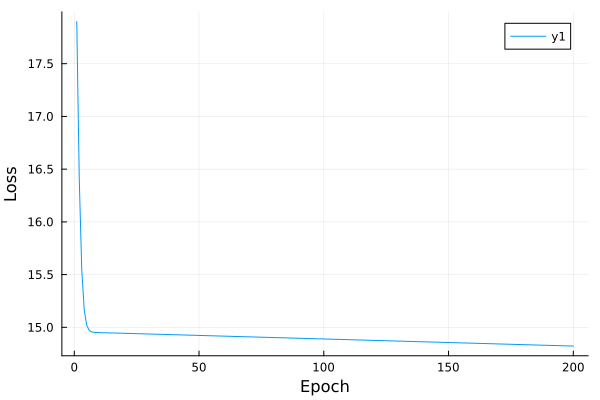

In [23]:
plot(losses; xlabel="Epoch", ylabel="Loss")

In [24]:
Y_test_pred = [optimizer(encoder(x)) for x in X_test];

In [9]:
true_deliveries, true_constraints = create_deliveries(X_A_test, X_C_test, Y_test)

(Any[Any[Delivery(0.285346664252601, 0.6273783228378499), Delivery(0.24729524152972113, 0.6628829842550245), Delivery(0.3783120422506709, 0.048379579810059865), Delivery(0.47991851433751576, 0.3707969674749293), Delivery(0.8264013413387067, 0.4703621739147121), Delivery(0.8239548385343233, 0.606538926136958), Delivery(0.1350309617043981, 0.3708253000664519), Delivery(0.132045408695281, 0.43123728701746944), Delivery(0.43696027617590094, 0.48756806489193616), Delivery(0.5256088107148651, 0.45820021948378514)  …  Delivery(0.39307066589540063, 0.4521628001019801), Delivery(0.2599478427455764, 0.34918721588169577), Delivery(0.19145244001483747, 0.4720641267535328), Delivery(0.12007041323853788, 0.3480334978059114), Delivery(0.2947361659722497, 0.32271153723750273), Delivery(0.518799375267699, 0.3719299120233189), Delivery(0.20720045402617457, 0.33598569900260533), Delivery(0.14732147941555362, 0.40038345148013094), Delivery(0.3374655945205997, 0.12195601148557526), Delivery(0.3748302976539

Evaluations of the true assignments and the resulting pipeline using TravelingSalesPerson with pickup and delivery

In [12]:
true_solution = []
@showprogress 30 "progress ..." for (delivery, constraint) in zip(true_deliveries, true_constraints)
   push!(true_solution, solve_tsp(delivery, constraint, Gurobi.Optimizer));
end

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...   4%|██                                     |  ETA: 0:15:32

progress ...   7%|███                                    |  ETA: 0:22:13

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...   8%|████                                   |  ETA: 0:26:51

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  13%|██████                                 |  ETA: 0:37:38

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  17%|███████                                |  ETA: 0:30:30

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  19%|████████                               |  ETA: 0:29:13

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  23%|█████████                              |  ETA: 0:26:07

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  25%|██████████                             |  ETA: 0:25:44

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  27%|███████████                            |  ETA: 0:29:31

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  30%|████████████                           |  ETA: 0:27:22

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  36%|███████████████                        |  ETA: 0:23:19

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  38%|███████████████                        |  ETA: 0:22:34

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  39%|████████████████                       |  ETA: 0:23:00

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  43%|█████████████████                      |  ETA: 0:26:41

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  45%|██████████████████                     |  ETA: 0:25:39

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  46%|██████████████████                     |  ETA: 0:25:15

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  51%|████████████████████                   |  ETA: 0:24:28

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  52%|█████████████████████                  |  ETA: 0:23:58

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  55%|██████████████████████                 |  ETA: 0:21:42

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  58%|███████████████████████                |  ETA: 0:21:26

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  61%|████████████████████████               |  ETA: 0:19:34

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  62%|█████████████████████████              |  ETA: 0:19:10

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  68%|███████████████████████████            |  ETA: 0:17:02

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  70%|████████████████████████████           |  ETA: 0:15:50

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  71%|████████████████████████████           |  ETA: 0:15:19

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  72%|█████████████████████████████          |  ETA: 0:14:50

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  76%|██████████████████████████████         |  ETA: 0:12:36

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  77%|███████████████████████████████        |  ETA: 0:12:06

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  78%|███████████████████████████████        |  ETA: 0:11:34

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  80%|████████████████████████████████       |  ETA: 0:10:41

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  82%|████████████████████████████████       |  ETA: 0:09:36

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  85%|██████████████████████████████████     |  ETA: 0:07:55

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  86%|██████████████████████████████████     |  ETA: 0:07:32

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  88%|███████████████████████████████████    |  ETA: 0:06:26

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  90%|████████████████████████████████████   |  ETA: 0:05:20

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  91%|████████████████████████████████████   |  ETA: 0:04:52

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  93%|█████████████████████████████████████  |  ETA: 0:03:49

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  95%|██████████████████████████████████████ |  ETA: 0:02:42

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  97%|██████████████████████████████████████ |  ETA: 0:01:36

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  99%|███████████████████████████████████████|  ETA: 0:00:32

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ... 100%|███████████████████████████████████████| Time: 0:52:41


Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


In [14]:
file = File(format"JLD2", "Data/true_output.jld2")
  
# Save data into the file
save(file, "delivery", true_deliveries, "constraint", true_constraints, "solutions", true_solution)

In [25]:
pred_deliveries, pred_constraints = create_deliveries(X_A_test, X_C_test, Y_test_pred)

(Any[Any[Delivery(0.1995734533842224, 0.434246987466408), Delivery(0.24729524152972113, 0.6628829842550245), Delivery(0.19145244001483747, 0.4720641267535328), Delivery(0.47991851433751576, 0.3707969674749293), Delivery(0.6726980265811969, 0.7858258237600879), Delivery(0.8239548385343233, 0.606538926136958), Delivery(0.1350309617043981, 0.3708253000664519), Delivery(0.132045408695281, 0.43123728701746944), Delivery(0.653247205235899, 0.5122223234632847), Delivery(0.5256088107148651, 0.45820021948378514)  …  Delivery(0.3589722063115998, 0.32732510728881525), Delivery(0.2599478427455764, 0.34918721588169577), Delivery(0.3374655945205997, 0.12195601148557526), Delivery(0.12007041323853788, 0.3480334978059114), Delivery(0.3723498751345028, 0.36890440134104485), Delivery(0.518799375267699, 0.3719299120233189), Delivery(0.420733505846175, 0.25116755458278495), Delivery(0.14732147941555362, 0.40038345148013094), Delivery(0.24145660980897274, 0.4248454319618809), Delivery(0.37483029765392484, 

In [26]:
pred_solution = []
@showprogress 30 "progress ..." for (delivery, constraint) in zip(pred_deliveries, pred_constraints)
   push!(pred_solution, solve_tsp(delivery, constraint, Gurobi.Optimizer));
end

progress ...   3%|██                                     |  ETA: 0:28:30

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...   6%|███                                    |  ETA: 0:28:00

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...   8%|████                                   |  ETA: 0:44:45

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  11%|█████                                  |  ETA: 0:43:45

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  13%|██████                                 |  ETA: 3:19:38

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  15%|██████                                 |  ETA: 2:52:41

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  19%|████████                               |  ETA: 2:16:00

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  22%|█████████                              |  ETA: 1:55:58

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  24%|██████████                             |  ETA: 1:51:12

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  25%|██████████                             |  ETA: 1:47:08

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  27%|███████████                            |  ETA: 1:43:27

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  28%|███████████                            |  ETA: 1:39:59

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  38%|███████████████                        |  ETA: 1:11:46

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  39%|████████████████                       |  ETA: 1:10:18

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  42%|█████████████████                      |  ETA: 1:03:19

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  43%|█████████████████                      |  ETA: 1:04:56

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  44%|██████████████████                     |  ETA: 1:14:50

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  45%|██████████████████                     |  ETA: 1:12:39

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  46%|██████████████████                     |  ETA: 1:11:15

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  48%|███████████████████                    |  ETA: 1:07:09

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  49%|████████████████████                   |  ETA: 1:05:11

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  51%|████████████████████                   |  ETA: 1:06:05

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  52%|█████████████████████                  |  ETA: 1:05:17

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  54%|██████████████████████                 |  ETA: 1:00:46

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  56%|██████████████████████                 |  ETA: 0:56:42

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  58%|███████████████████████                |  ETA: 0:52:57

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  60%|████████████████████████               |  ETA: 0:49:48

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  61%|████████████████████████               |  ETA: 0:48:58

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  62%|█████████████████████████              |  ETA: 0:47:57

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  65%|██████████████████████████             |  ETA: 0:45:27

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  67%|███████████████████████████            |  ETA: 0:42:05

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  68%|███████████████████████████            |  ETA: 0:43:07

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  69%|███████████████████████████            |  ETA: 0:41:42

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  70%|████████████████████████████           |  ETA: 0:40:10

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  71%|████████████████████████████           |  ETA: 0:39:03

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  72%|█████████████████████████████          |  ETA: 0:38:06

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  74%|█████████████████████████████          |  ETA: 0:34:58

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  75%|██████████████████████████████         |  ETA: 0:33:20

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  76%|██████████████████████████████         |  ETA: 0:32:14

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  77%|███████████████████████████████        |  ETA: 0:31:02

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  78%|███████████████████████████████        |  ETA: 0:29:29

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  79%|███████████████████████████████        |  ETA: 0:28:04

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  80%|████████████████████████████████       |  ETA: 0:26:42

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  81%|████████████████████████████████       |  ETA: 0:25:16

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  82%|████████████████████████████████       |  ETA: 0:23:59

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  83%|█████████████████████████████████      |  ETA: 0:22:42

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  85%|██████████████████████████████████     |  ETA: 0:20:27

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  86%|██████████████████████████████████     |  ETA: 0:19:48

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  88%|███████████████████████████████████    |  ETA: 0:16:41

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  89%|███████████████████████████████████    |  ETA: 0:15:11

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  90%|████████████████████████████████████   |  ETA: 0:13:45

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  91%|████████████████████████████████████   |  ETA: 0:12:19

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  93%|█████████████████████████████████████  |  ETA: 0:09:43

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  95%|██████████████████████████████████████ |  ETA: 0:06:50

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ...  97%|██████████████████████████████████████ |  ETA: 0:04:03

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


progress ... 100%|███████████████████████████████████████| Time: 2:11:38


Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-28


In [27]:
file = File(format"JLD2", "Data/addap_output_0,1.jld2")
  
# Save data into the file
save(file, "delivery", pred_deliveries, "constraint", pred_constraints, "solutions", pred_solution, "trainings_losses", losses)